In [259]:
from scipy.io import loadmat
import proplot as pplt
import pandas as pd
import numpy as np
import sys
sys.path.append('../../drifter')
from importlib import reload
import utilities.cleaning as clean
import utilities.interpolation as interp
import xarray as xr
clean = reload(clean)
interp = reload(interp)

# Buoy processing for the absolute and relative dispersion paper

Numerous goals. First and foremost, the goal is to have a clean dataset that has been QC'd in a consistent way. Along the way, it is also important to filter the data for relevance to the study: we are only looking at data for the Fram Strait and East Greenland regions. Data comes from multiple sources and has multiple formats. It is possible (and even likely) that the IABP WebData includes all the additional drifter data from e.g. Damocles.

# N-ICE 2015
Status: preliminary version done. Some big gaps to consider.

In [300]:
import json
import os
min_size = 300
dataloc = '../../data/NICE2015/'
saveloc = '../../data/cleaned_disp_paper/'

files = os.listdir(dataloc)
files = [f for f in files if f.split('.')[-1] == 'json']
nice2015_data = {}
for file in files:
    data = json.load(open(dataloc + file))
    df = pd.DataFrame(data = data['geometry']['coordinates'],
                  columns=['longitude', 'latitude'],
                index=data['properties']['measured'])
    df.index = pd.to_datetime(df.index)

    df['quality'] = data['properties']['quality']
    df = df.sort_index()
    
    flag_date = clean.check_dates(df, date_index=True)
    flag_pos = clean.check_duplicate_positions(df, date_index=True)
    df = df.loc[~flag_date & ~flag_pos]
    
    # manual adjustment of two buoys:
    if file == 'SVP_2015a.json':
        repair = slice('2015-04-24 08:00:00+00:00', '2015-05-18 00:00:00+00:00')
        df.loc[repair, 'longitude'] = -np.abs(df.loc[repair, 'longitude'])

    elif file == 'SVP_2015c.json':
        repair = slice('2015-04-26 12:00:00+00:00', '2015-05-22 15:00:00+00:00')
        df.loc[repair, 'longitude'] = -np.abs(df.loc[repair, 'longitude'])    
    
    # this gets the x and y coords as well as speed
    df = clean.calc_speed_for_outlier_check(df, date_index=True)

    # global speed check
    flag_speed = df.speed > 1
    df = df.loc[~flag_speed]
    
    # remove orphan data
    flag_gap = clean.check_dates(df, check_gaps=True, date_index=True, gap_window='24H', gap_threshold=11)
    df = df.loc[~flag_gap]

    
    # align to hourly and save
    if len(df) > min_size:
        df = interp.regrid_buoy_track(df, precision='1H').loc[:, ['longitude', 'latitude']]
        flag_gap = clean.check_dates(df, check_gaps=True, date_index=True, gap_window='24H', gap_threshold=11)
        df = df.loc[~flag_gap]

        if len(df) > min_size:
            nice2015_data[file.replace('.json', '')] = df.dropna()
    

for buoy in nice2015_data:
    print(buoy, len(nice2015_data[buoy]))
    nice2015_data[buoy].to_csv(saveloc + 'NICE2015_' + buoy + '.csv')

SIMBA_2015g 426
WAVE_2015f 883
SNOW_2015a 1774
IMB_2016a 1278
SVP_2015b 5152
RIDGE_2015a 498
AFAR_2015a 795
IMB-B_2015a 561
SIMBA_2015a 1447
IMB_2015a 1013
IMB-B_2015b 505
WAVE_2015c 682
SNOW_2015d 1566
SNOW_2015e 1215
WAVE_2015b 879
RIDGE_2015b 407
AFAR_2015b 621
IMB-B_2015c 550
SVP_2015a 4496
WAVE_2015e 810
SNOW_2015b 1092
SIMBA_2015d 1864
SNOW_2015c 1214
WAVE_2015d 339


/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


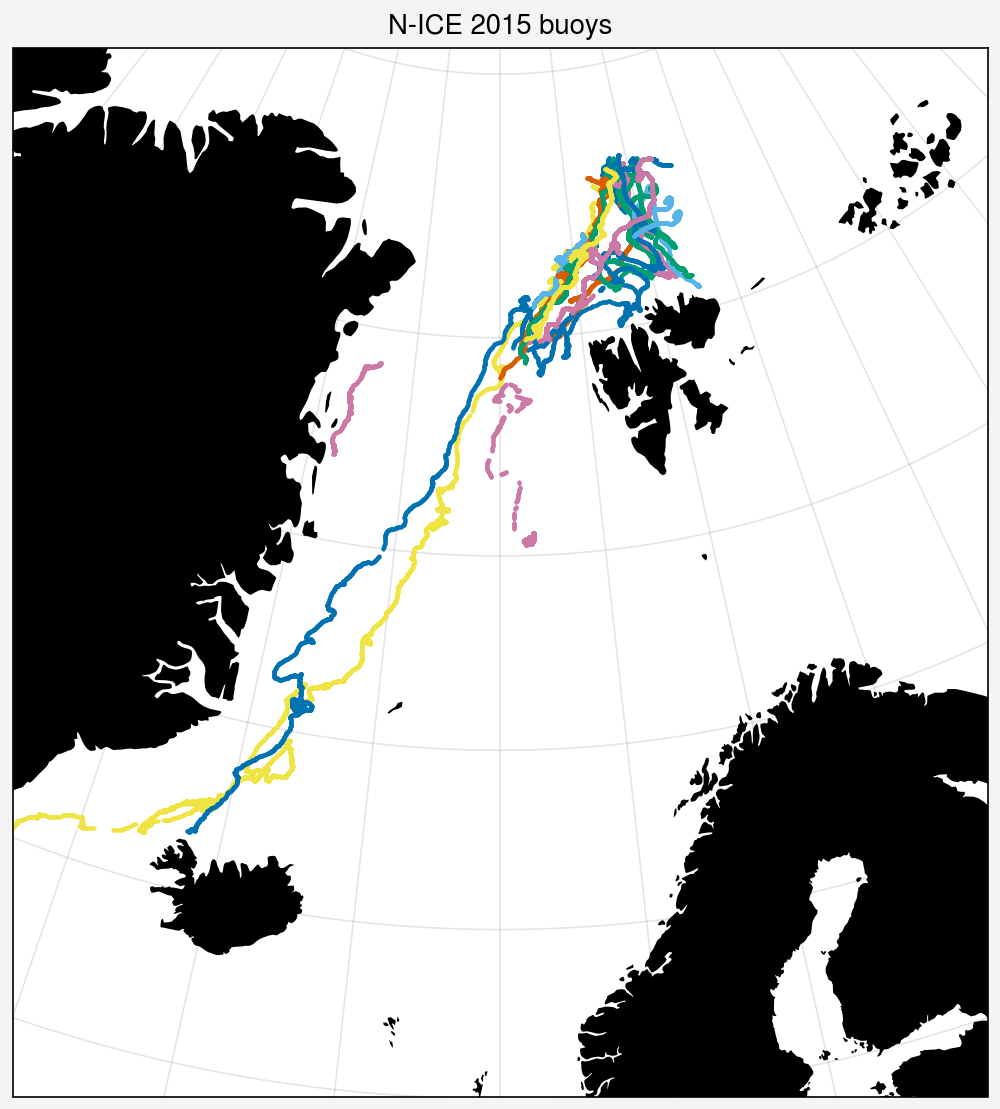

In [302]:

fig, ax = pplt.subplots(proj='lcc', proj_kw={'lon_0': 0}, width=5)
pplt.rc.reso='med'
ax.format(land=True, lonlim=(-30,30), latlim=(60,85))
for buoy in nice2015_data:
    buoy_df = nice2015_data[buoy].copy()
    ax.plot(buoy_df.longitude, buoy_df.latitude, marker='.', lw=0, ms=1)
ax.format(title='N-ICE 2015 buoys')

ACSYS2003_calib_buoy_20811 1441
ACSYS2003_calib_buoy_20835 2139
ACSYS2003_calib_buoy_20627 1266
ACSYS2003_calib_buoy_20756 971
ACSYS2003_calib_buoy_20601 2213
ACSYS2003_calib_buoy_20755 2002


/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


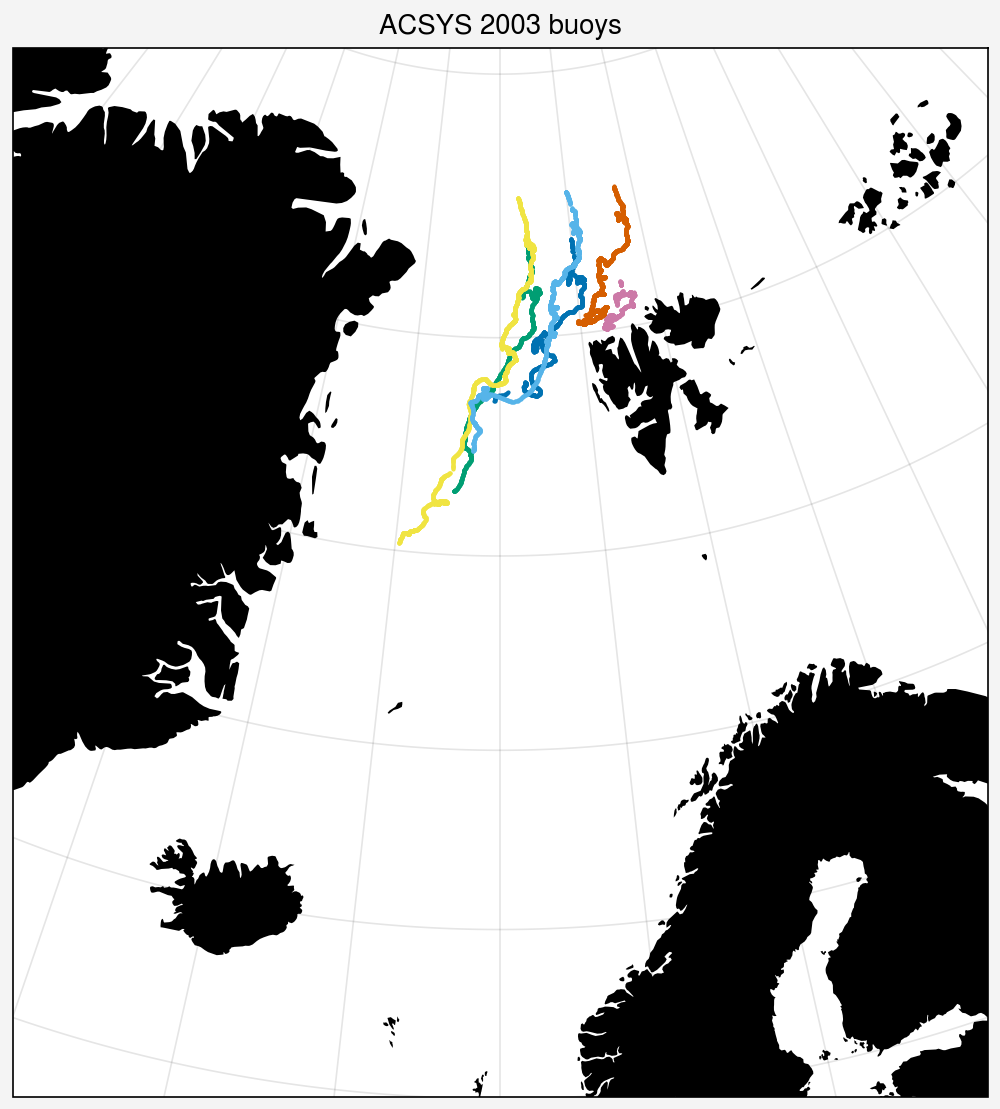

In [303]:
min_size = 300
dataloc = '../../data/ACSYS2003_calib_buoy/'
saveloc = '../../data/cleaned_disp_paper/'

files = os.listdir(dataloc)
files = [f for f in files if f.split('_')[-1] != 'raw.nc']
files = [f for f in files if f.split('.')[-1] == 'nc']

buoy_data = {}
for file in files:
    with xr.open_dataset(dataloc + file) as ds:
        df = ds[['latitude', 'longitude']].to_dataframe()
        df.index = pd.to_datetime(df.index)
        flag_date = clean.check_dates(df, date_index=True)
        flag_pos = clean.check_duplicate_positions(df, date_index=True)
        df = df.loc[~flag_date & ~flag_pos]
        df = clean.calc_speed_for_outlier_check(df, date_index=True)

        # global speed check
        flag_speed = df.speed > 1
        df = df.loc[~flag_speed]

        # remove orphan data
        flag_gap = clean.check_dates(df, check_gaps=True, date_index=True, gap_window='24H', gap_threshold=11)
        df = df.loc[~flag_gap]

        # align to hourly and save
        if len(df) > min_size:
            df = interp.regrid_buoy_track(df, precision='1H').loc[:, ['longitude', 'latitude']]
            flag_gap = clean.check_dates(df, check_gaps=True, date_index=True, gap_window='24H', gap_threshold=11)
            df = df.loc[~flag_gap]

            if len(df) > min_size:
                buoy_data[file.replace('.nc', '')] = df.dropna()
for buoy in buoy_data:
    print(buoy, len(buoy_data[buoy]))
    buoy_data[buoy].to_csv(saveloc + buoy + '.csv')   
    
fig, ax = pplt.subplots(proj='lcc', proj_kw={'lon_0': 0}, width=5)
pplt.rc.reso='med'
ax.format(land=True, lonlim=(-30,30), latlim=(60,85))
for buoy in buoy_data:
    buoy_df = buoy_data[buoy].copy()
    ax.plot(buoy_df.longitude, buoy_df.latitude, marker='.', lw=0, ms=1)
ax.format(title='ACSYS 2003 buoys')

In [ ]:
# 1999 data will take more careful processing

FRAMZY2002_calib_buoy_09438 278 273
FRAMZY2002_calib_buoy_09439 404
FRAMZY2002_calib_buoy_09437 1342
FRAMZY2002_calib_buoy_09433 838
FRAMZY2002_calib_buoy_09432 1004
FRAMZY2002_calib_buoy_09436 1137
FRAMZY2002_calib_buoy_09431 457
FRAMZY2002_calib_buoy_09435 1849
FRAMZY2002_calib_buoy_09440 311
FRAMZY2002_calib_buoy_09434 1021
FRAMZY2002_calib_buoy_09492 975
FRAMZY2002_calib_buoy_09430 435


/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


FRAMZY2007_calib_buoy_73392 284 269
FRAMZY2007_calib_buoy_73408 464
FRAMZY2007_calib_buoy_73395 927
FRAMZY2007_calib_buoy_73394 764
FRAMZY2007_calib_buoy_73409 924
FRAMZY2007_calib_buoy_73412 914
FRAMZY2007_calib_buoy_73402 637
FRAMZY2007_calib_buoy_73403 744
FRAMZY2007_calib_buoy_73404 447
FRAMZY2007_calib_buoy_73399 934
FRAMZY2007_calib_buoy_73410 681
FRAMZY2007_calib_buoy_73400 784
FRAMZY2007_calib_buoy_73411 736
FRAMZY2007_calib_buoy_73401 792
FRAMZY2007_calib_buoy_73393 341
FRAMZY2007_calib_buoy_73396 521


/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


FRAMZY2008_calib_buoy_73414 114 100
FRAMZY2008_calib_buoy_73407 551
FRAMZY2008_calib_buoy_73413 818
FRAMZY2008_calib_buoy_73406 629
FRAMZY2008_calib_buoy_73397 823
FRAMZY2008_calib_buoy_73398 441
FRAMZY2008_calib_buoy_73405 852


/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


FRAMZY2009_calib_buoy_92558 1824
FRAMZY2009_calib_buoy_92559 2058
FRAMZY2009_calib_buoy_92556 2990
FRAMZY2009_calib_buoy_92557 710
FRAMZY2009_calib_buoy_92553 1768
FRAMZY2009_calib_buoy_92555 2087


/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


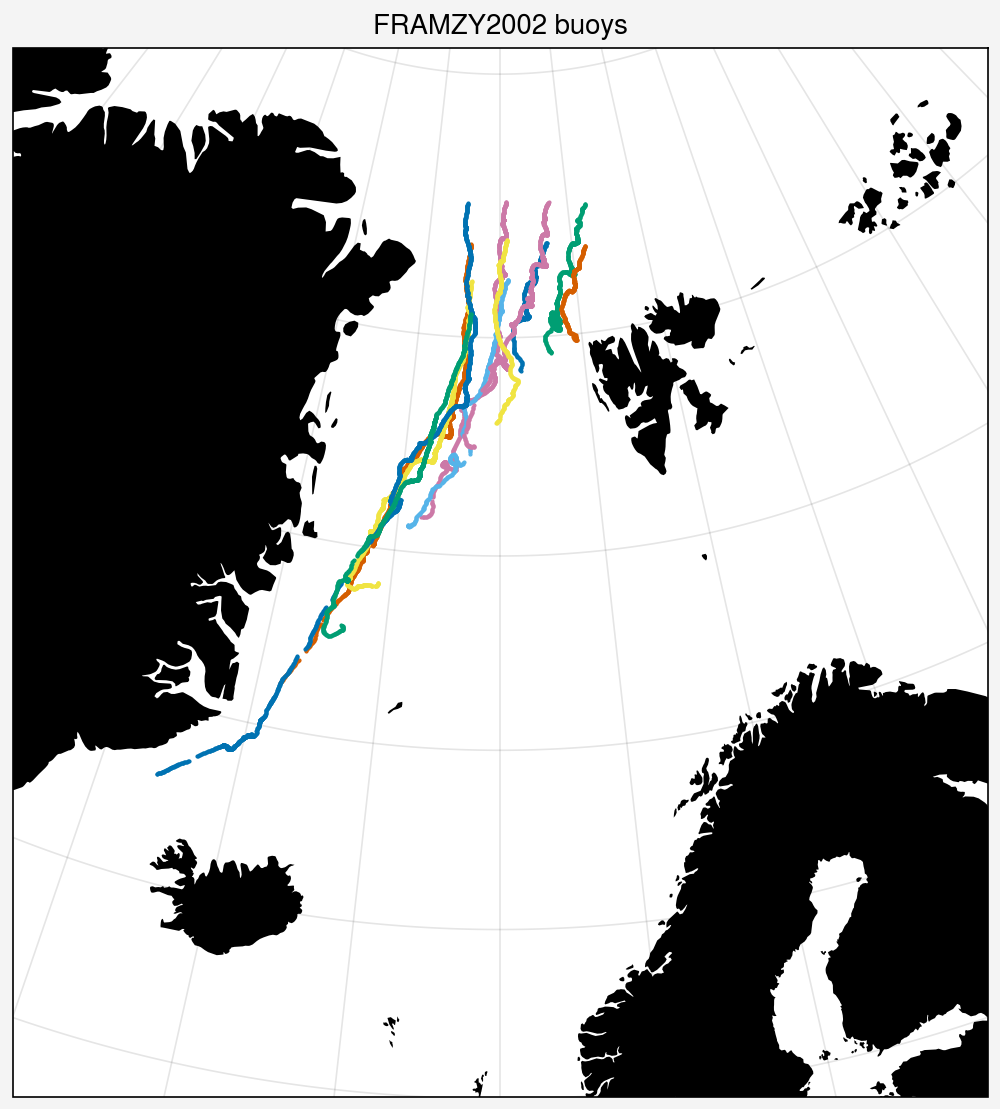

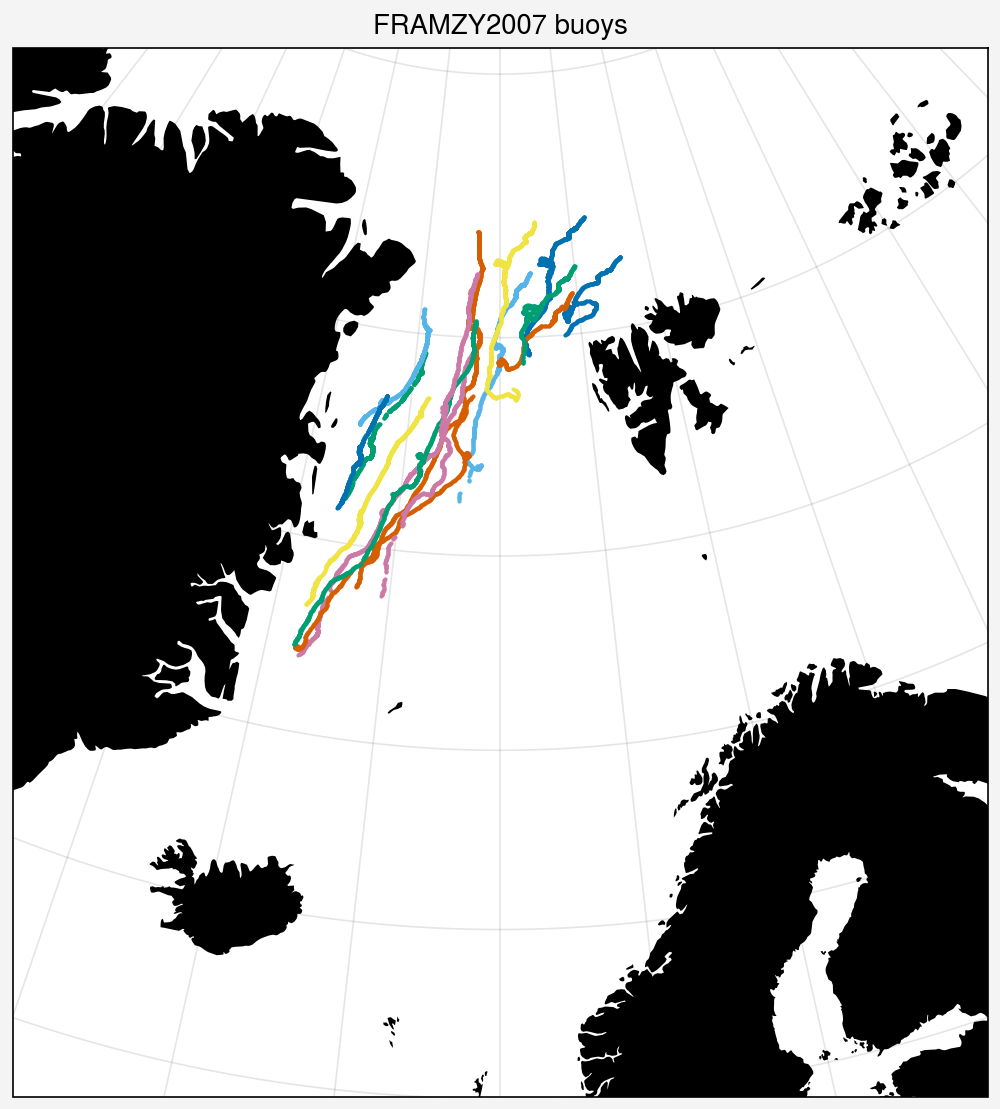

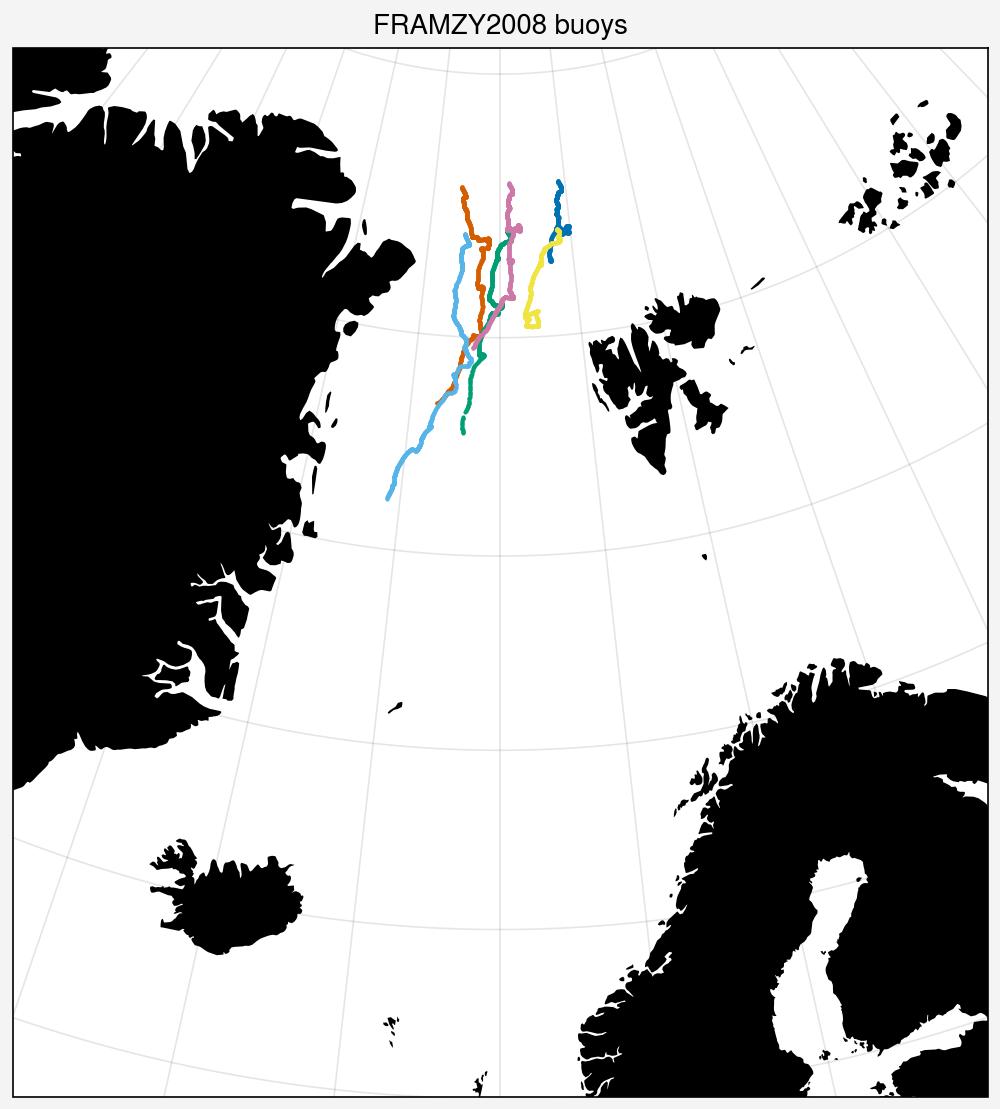

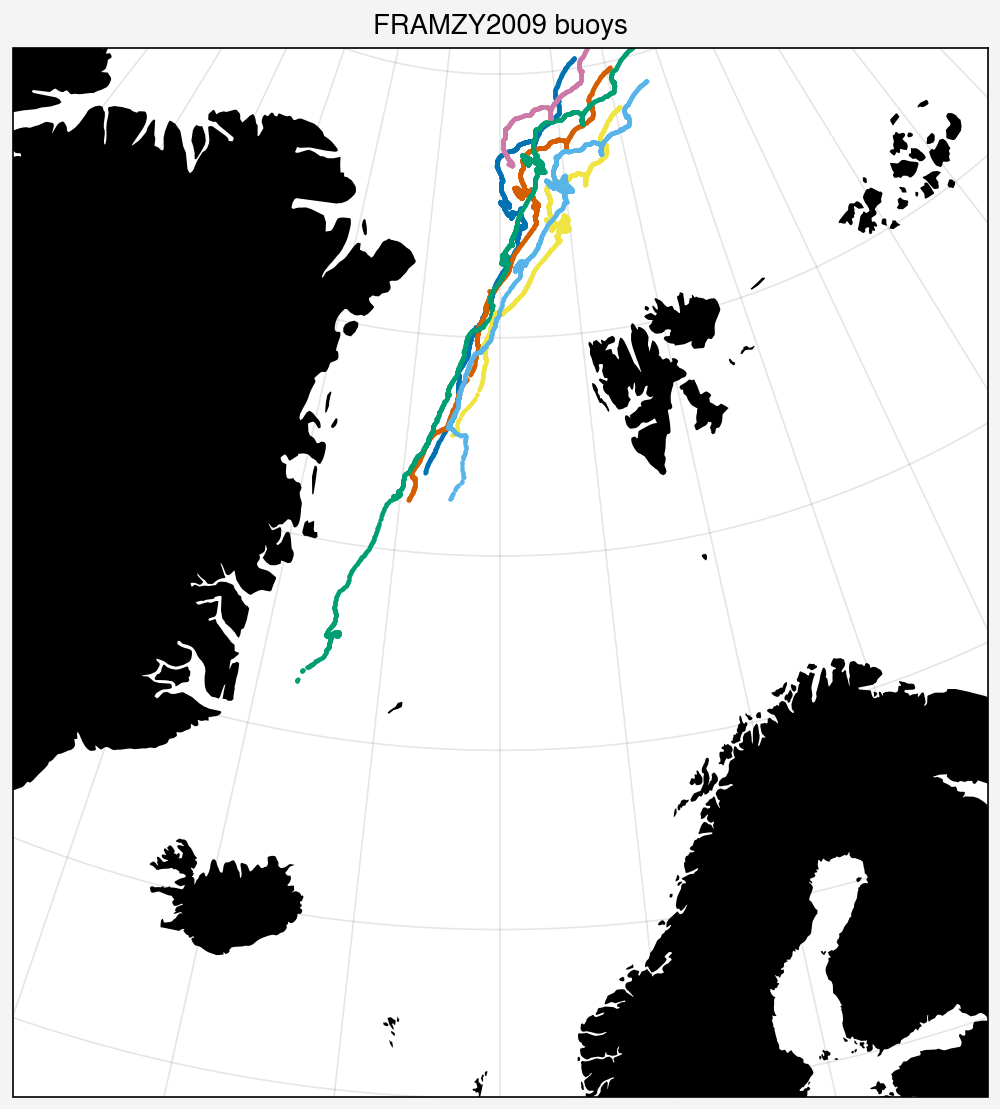

In [321]:
min_size = 300
for dataset in ['FRAMZY2002_calib_buoy', 'FRAMZY2007_calib_buoy',
                'FRAMZY2008_calib_buoy', 'FRAMZY2009_calib_buoy']:
    dataloc = '../../data/FRAMZY/' + dataset + '/'
    saveloc = '../../data/cleaned_disp_paper/'

    files = os.listdir(dataloc)
    files = [f for f in files if f.split('_')[-1] != 'raw.nc']
    files = [f for f in files if f.split('.')[-1] == 'nc']

    buoy_data = {}
    for file in files:
        with xr.open_dataset(dataloc + file) as ds:
            df = ds[['latitude', 'longitude']].to_dataframe()
            n = len(df)
            df.index = pd.to_datetime(df.index)
            flag_date = clean.check_dates(df, date_index=True)
            flag_pos = clean.check_duplicate_positions(df, date_index=True)
            df = df.loc[~flag_date & ~flag_pos]
            df = clean.calc_speed_for_outlier_check(df, date_index=True)

            # global speed check
            flag_speed = df.speed > 1
            df = df.loc[~flag_speed]

            # remove orphan data
            flag_gap = clean.check_dates(df, check_gaps=True, date_index=True, gap_window='24H', gap_threshold=4)
            df = df.loc[~flag_gap]

            # align to hourly and save
            if len(df) > min_size:
                df = interp.regrid_buoy_track(df, precision='1H').loc[:, ['longitude', 'latitude']]
                flag_gap = clean.check_dates(df, check_gaps=True, date_index=True, gap_window='24H', gap_threshold=4)
                df = df.loc[~flag_gap]

                if len(df) > min_size:
                    buoy_data[file.replace('.nc', '')] = df.dropna()
            else:
                print(file.replace('.nc', ''), n, len(df))
    for buoy in buoy_data:
        print(buoy, len(buoy_data[buoy]))
        buoy_data[buoy].to_csv(saveloc + buoy + '.csv')
    fig, ax = pplt.subplots(proj='lcc', proj_kw={'lon_0': 0}, width=5)
    pplt.rc.reso='med'
    ax.format(land=True, lonlim=(-30,30), latlim=(60,85))
    for buoy in buoy_data:
        buoy_df = buoy_data[buoy].copy()
        ax.plot(buoy_df.longitude, buoy_df.latitude, marker='.', lw=0, ms=1)
    ax.format(title=dataset.split('_')[0] + ' buoys')

DAMOCLES2007_calib_buoy_70445 5691
DAMOCLES2007_calib_buoy_70455 1185
DAMOCLES2007_calib_buoy_70441 2375
DAMOCLES2007_calib_buoy_70451 1462
DAMOCLES2007_calib_buoy_70440 3926
DAMOCLES2007_calib_buoy_70450 3431
DAMOCLES2007_calib_buoy_70444 3939
DAMOCLES2007_calib_buoy_70454 1685
DAMOCLES2007_calib_buoy_70443 2333
DAMOCLES2007_calib_buoy_70453 3103
DAMOCLES2007_calib_buoy_70447 2540
DAMOCLES2007_calib_buoy_70446 489
DAMOCLES2007_calib_buoy_70442 3776
DAMOCLES2007_calib_buoy_70452 998
DAMOCLES2007_calib_buoy_70449 1104
DAMOCLES2007_calib_buoy_70448 1623


/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


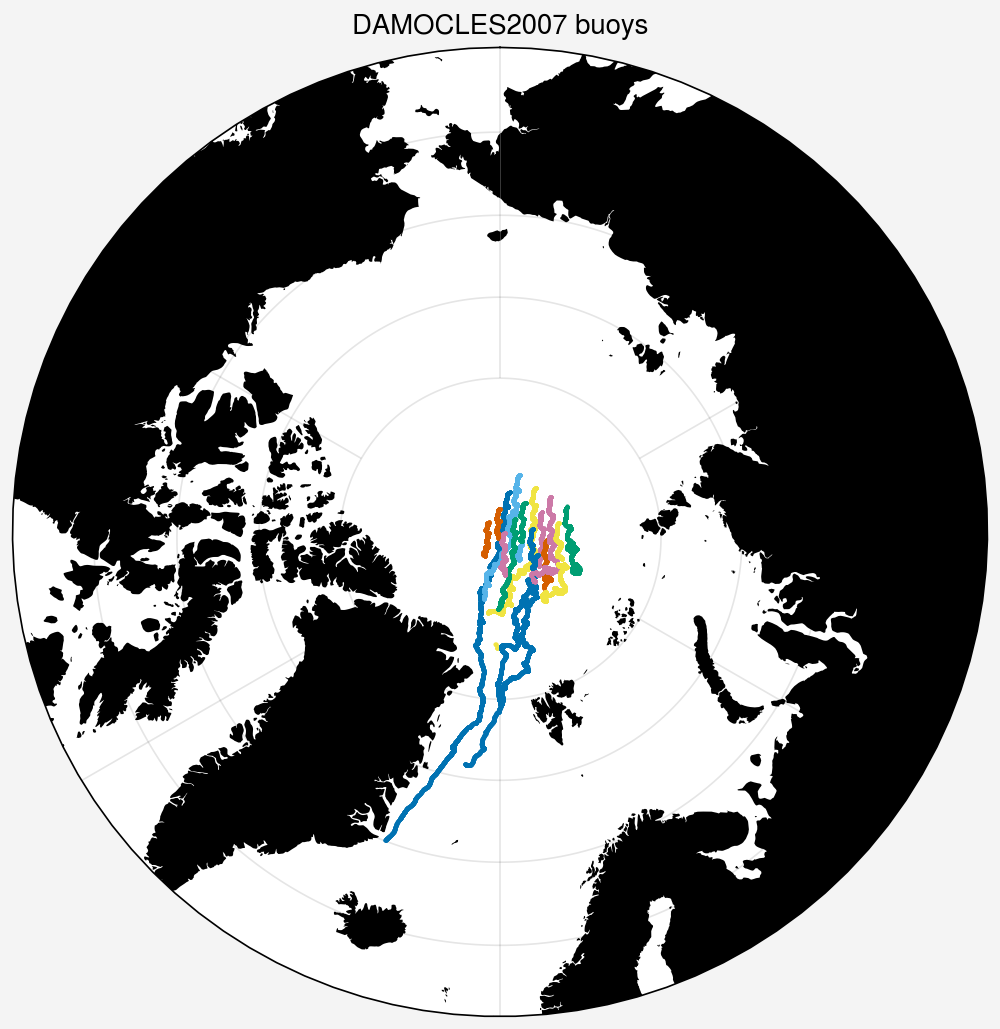

In [320]:
min_size = 300
dataloc = '../../data/DAMOCLES2007_calib_buoy/'
saveloc = '../../data/cleaned_disp_paper/'

files = os.listdir(dataloc)
files = [f for f in files if f.split('_')[-1] != 'raw.nc']
files = [f for f in files if f.split('.')[-1] == 'nc']

buoy_data = {}
for file in files:
    with xr.open_dataset(dataloc + file) as ds:
        df = ds[['latitude', 'longitude']].to_dataframe()
        n = len(df)
        df.index = pd.to_datetime(df.index)
        flag_date = clean.check_dates(df, date_index=True)
        flag_pos = clean.check_duplicate_positions(df, date_index=True)
        df = df.loc[~flag_date & ~flag_pos]
        df = clean.calc_speed_for_outlier_check(df, date_index=True)

        # global speed check
        flag_speed = df.speed > 1
        df = df.loc[~flag_speed]

        # remove orphan data
        flag_gap = clean.check_dates(df, check_gaps=True, date_index=True, gap_window='24H', gap_threshold=4)
        df = df.loc[~flag_gap]

        # align to hourly and save
        if len(df) > min_size:
            df = interp.regrid_buoy_track(df, precision='1H').loc[:, ['longitude', 'latitude']]
            flag_gap = clean.check_dates(df, check_gaps=True, date_index=True, gap_window='24H', gap_threshold=4)
            df = df.loc[~flag_gap]

            if len(df) > min_size:
                buoy_data[file.replace('.nc', '')] = df.dropna()
        else:
            print(file.replace('.nc', ''), n, len(df))
for buoy in buoy_data:
    print(buoy, len(buoy_data[buoy]))
    buoy_data[buoy].to_csv(saveloc + buoy + '.csv')    

fig, ax = pplt.subplots(proj='npstere', proj_kw={'lon_0': 0}, width=5)
pplt.rc.reso='med'
ax.format(land=True, boundinglat=60)
for buoy in buoy_data:
    buoy_df = buoy_data[buoy].copy()
    ax.plot(buoy_df.longitude, buoy_df.latitude, marker='.', lw=0, ms=1)
ax.format(title='DAMOCLES2007' + ' buoys')

DAMOCLES2008_paws_buoy_325420 511 247
DAMOCLES2008_paws_buoy_329410 1099
DAMOCLES2008_paws_buoy_146100 1781
DAMOCLES2008_paws_buoy_141100 1605
DAMOCLES2008_paws_buoy_326420 1678
DAMOCLES2008_paws_buoy_329380 1150
DAMOCLES2008_paws_buoy_338180 1951
DAMOCLES2008_paws_buoy_321420 1607
DAMOCLES2008_paws_buoy_321430 1345


/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


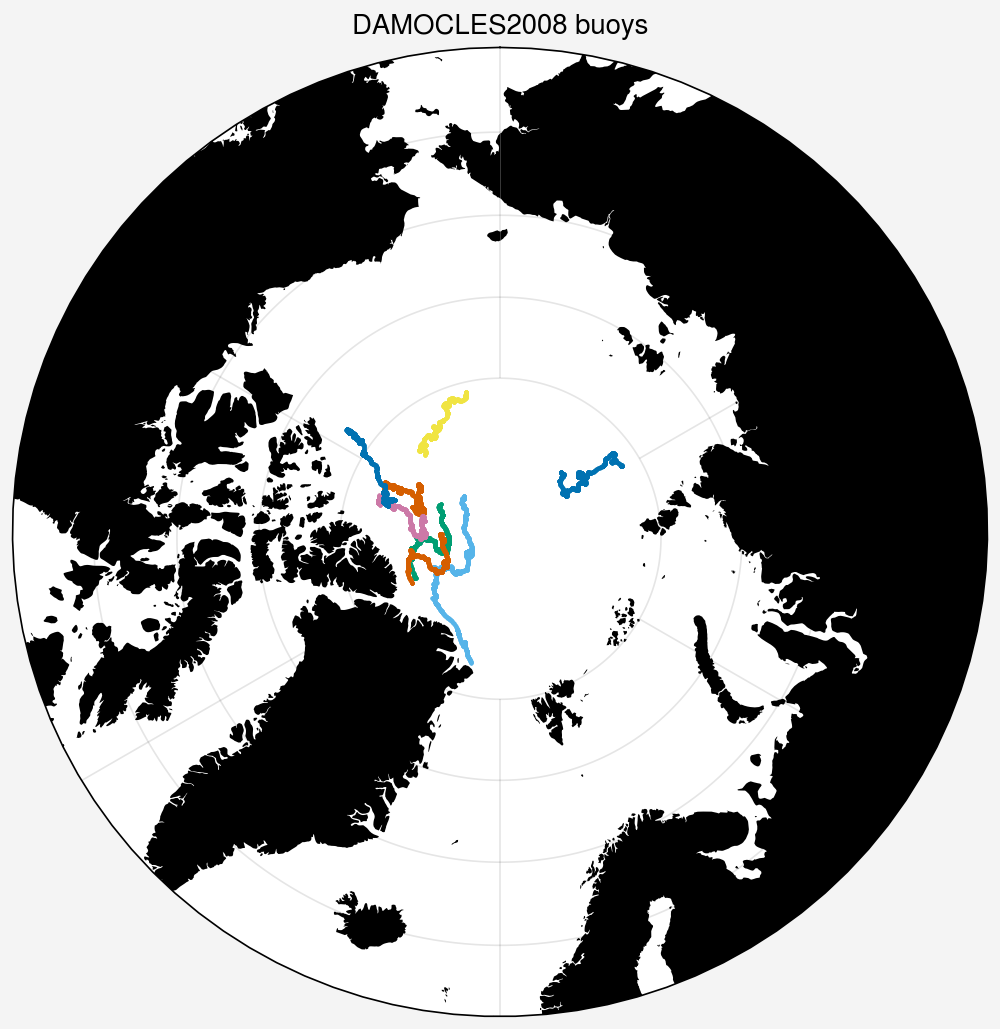

In [322]:
min_size = 300
dataloc = '../../data/DAMOCLES2008_paws_buoy/'
saveloc = '../../data/cleaned_disp_paper/'

files = os.listdir(dataloc)
files = [f for f in files if f.split('_')[-1] != 'raw.nc']
files = [f for f in files if f.split('.')[-1] == 'nc']

buoy_data = {}
for file in files:
    with xr.open_dataset(dataloc + file) as ds:
        df = ds[['latitude', 'longitude']].to_dataframe()
        n = len(df)
        df.index = pd.to_datetime(df.index)
        flag_date = clean.check_dates(df, date_index=True)
        flag_pos = clean.check_duplicate_positions(df, date_index=True)
        df = df.loc[~flag_date & ~flag_pos]
        df = clean.calc_speed_for_outlier_check(df, date_index=True)

        # global speed check
        flag_speed = df.speed > 1
        df = df.loc[~flag_speed]

        # remove orphan data
        flag_gap = clean.check_dates(df, check_gaps=True, date_index=True, gap_window='24H', gap_threshold=4)
        df = df.loc[~flag_gap]

        # align to hourly and save
        if len(df) > min_size:
            df = interp.regrid_buoy_track(df, precision='1H').loc[:, ['longitude', 'latitude']]
            flag_gap = clean.check_dates(df, check_gaps=True, date_index=True, gap_window='24H', gap_threshold=4)
            df = df.loc[~flag_gap]

            if len(df) > min_size:
                buoy_data[file.replace('.nc', '')] = df.dropna()
        else:
            print(file.replace('.nc', ''), n, len(df))
for buoy in buoy_data:
    print(buoy, len(buoy_data[buoy]))
    buoy_data[buoy].to_csv(saveloc + buoy + '.csv')    

fig, ax = pplt.subplots(proj='npstere', proj_kw={'lon_0': 0}, width=5)
pplt.rc.reso='med'
ax.format(land=True, boundinglat=60)
for buoy in buoy_data:
    buoy_df = buoy_data[buoy].copy()
    ax.plot(buoy_df.longitude, buoy_df.latitude, marker='.', lw=0, ms=1)
ax.format(title='DAMOCLES2008' + ' buoys')

Additional IABP data obtained from the WebData interface - TBD